In [1]:
# Core data libraries
import pandas as pd
import numpy as np

# Statistichal
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest

# Vizualizacion
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(style="whitegrid", font_scale=1.2)

In [3]:
df_offer = pd.read_parquet('../../data/01_processed/ofertas_relampago.parquet')

df_offer = df_offer.loc[df_offer["SOLD_QUANTITY"].notnull()].reset_index(drop = True).copy()

In [4]:
results = []

for vertical, subdf in df_offer.groupby("VERTICAL"):
    free = subdf.loc[subdf["SHIPPING_PAYMENT_TYPE"] == "free_shipping", "SOLD_QUANTITY"]
    paid = subdf.loc[subdf["SHIPPING_PAYMENT_TYPE"] != "free_shipping", "SOLD_QUANTITY"]
    
    if len(free) > 1 and len(paid) > 1:
        # Normality check (Shapiro-Wilk)
        _, p_norm_free = shapiro(free)
        _, p_norm_paid = shapiro(paid)
        normal_free = p_norm_free > 0.05
        normal_paid = p_norm_paid > 0.05
        
        # Variance homogeneity (Levene)
        _, p_var = levene(free, paid)
        equal_var = p_var > 0.05
        
        # Only run t-test if both normal
        if normal_free and normal_paid:
            stat, p = ttest_ind(free, paid, equal_var=equal_var)
            mean_diff = free.mean() - paid.mean()
            pooled_std = np.sqrt(((free.std() ** 2) + (paid.std() ** 2)) / 2)
            d = mean_diff / pooled_std
        else:
            stat, p, d, mean_diff = np.nan, np.nan, np.nan, np.nan
        
        results.append({
            "VERTICAL": vertical,
            "Normal_Free": normal_free,
            "Normal_Paid": normal_paid,
            "Equal_Var": equal_var,
            "Mean Diff": mean_diff,
            "Cohen's d": d,
            "p-value": p
        })

vertical_results = pd.DataFrame(results).sort_values("p-value", na_position="last")
display(vertical_results)

,VERTICAL,Normal_Free,Normal_Paid,Equal_Var,Mean Diff,Cohen's d,p-value
0,ACC,False,False,False,NaN,NaN,NaN
1,APP & SPORTS,False,False,False,NaN,NaN,NaN
2,BEAUTY & HEALTH,False,False,False,NaN,NaN,NaN
3,CE,False,False,False,NaN,NaN,NaN
4,CPG,False,False,False,NaN,NaN,NaN
5,ENTERTAINMENT,False,False,True,NaN,NaN,NaN
6,HOME & INDUSTRY,False,False,False,NaN,NaN,NaN
7,OTHERS,False,False,False,NaN,NaN,NaN
8,T & B,False,False,False,NaN,NaN,NaN


<b> Como observamos que todos las nuestras verticales fallaran en los testes de Normalidad Se va aplicar un Mann–Whitney U test </b>

<b> ¿El envío gratis impacta las ventas? </b>
- H₀: El promedio de unidades vendidas es el mismo para ofertas con y sin envío gratis.
- H₁: El promedio de unidades vendidas es diferente entre ambos grupos.

In [5]:
# DataFrame para guardar resultados
results = []

for vertical, subdf in df_offer.groupby("VERTICAL"):
    free = subdf.loc[subdf["SHIPPING_PAYMENT_TYPE"] == "free_shipping", "SOLD_QUANTITY"]
    paid = subdf.loc[subdf["SHIPPING_PAYMENT_TYPE"] != "free_shipping", "SOLD_QUANTITY"]

    if len(free) > 1 and len(paid) > 1:
        stat, p = mannwhitneyu(free, paid, alternative='two-sided')
        mean_diff = free.mean() - paid.mean()
        pooled_std = np.sqrt(((free.std() ** 2) + (paid.std() ** 2)) / 2)
        d = mean_diff / pooled_std

        results.append({
            "VERTICAL": vertical,
            "Mean Diff": mean_diff,
            "Cohen's d": d,
            "p-value": p
        })


# Convertir a DataFrame
vertical_results = pd.DataFrame(results).sort_values("p-value")
display(vertical_results)

,VERTICAL,Mean Diff,Cohen's d,p-value
2,BEAUTY & HEALTH,-36.170143,-0.394827,3.535410e-79
1,APP & SPORTS,-1.439560,-0.167314,1.063502e-54
6,HOME & INDUSTRY,-1.577203,-0.210739,1.477228e-38
0,ACC,-2.055634,-0.552378,4.519227e-24
3,CE,-0.980142,-0.140489,2.118346e-23
8,T & B,-2.282226,-0.568242,2.037558e-18
4,CPG,-2.979505,-0.539811,8.450009e-17
7,OTHERS,-1.571183,-0.514562,2.476090e-02
5,ENTERTAINMENT,0.258846,0.187766,4.545024e-01


<b> Las diferencias más grandes y estadísticamente significativas se observan en </b>
- BEAUTY & HEALTH: ≈ 36 unidades menos con envío gratis (d = −0.39, efecto moderado).
- Únicamente en ENTERTAINMENT la diferencia no es estadísticamente significativa (p > 0.05).
- Puede ser un incentivo ineficaz o incluso contraproducente en ciertas verticales.
- En algunas, podría estar ligado a estrategias de precios o promociones que no favorecen la conversión.

<b> ¿Todas las verticales convierten igual? </b>
- H₀ (nula): La media de unidades vendidas es la misma en todas las verticales.
- H₁ (alternativa): Al menos una vertical difiere en su media de unidades vendidas.

In [6]:
# Grupos para ANOVA
groups = [df_offer.loc[df_offer["VERTICAL"] == v, "SOLD_QUANTITY"]
          for v in df_offer["VERTICAL"].unique()]

In [7]:
f_stat, p_anova = f_oneway(*groups)
print(f"[ANOVA] F={f_stat:.2f}, p-value={p_anova:.3e}")

[ANOVA] F=310.74, p-value=0.000e+00


### El ANOVA previo mostró que las medias de ventas por vertical no son iguales (p < 0.05), lo que justifica el análisis post-hoc.

In [8]:
# Post-hoc: Tukey HSD (qué pares difieren)
tukey = pairwise_tukeyhsd(endog=df_offer["SOLD_QUANTITY"],
                          groups=df_offer["VERTICAL"],
                          alpha=0.05)

c:\Users\leand\anaconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [9]:
tukey_df = pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])
display(tukey_df.sort_values("p-adj").head(15))

,group1,group2,meandiff,p-adj,lower,upper,reject
17,BEAUTY & HEALTH,ENTERTAINMENT,-38.2250,0.0000,-48.5030,-27.9470,True
1,ACC,BEAUTY & HEALTH,36.2917,0.0000,32.0618,40.5216,True
20,BEAUTY & HEALTH,T & B,-37.2229,0.0000,-42.4409,-32.0048,True
19,BEAUTY & HEALTH,OTHERS,-37.2306,0.0000,-49.7201,-24.7411,True
8,APP & SPORTS,BEAUTY & HEALTH,36.3717,0.0000,33.7638,38.9795,True
18,BEAUTY & HEALTH,HOME & INDUSTRY,-35.1811,0.0000,-37.9093,-32.4529,True
16,BEAUTY & HEALTH,CPG,-35.5114,0.0000,-39.8771,-31.1458,True
15,BEAUTY & HEALTH,CE,-35.4099,0.0000,-38.2513,-32.5684,True
12,APP & SPORTS,HOME & INDUSTRY,1.1905,0.8570,-1.2751,3.6562,False
34,HOME & INDUSTRY,T & B,-2.0418,0.9500,-7.1902,3.1067,False


<b> BEAUTY & HEALTH sobresale significativamente sobre casi todas las demás verticales: </b>
- Ventas promedio 36–38 unidades más que ACC y APP & SPORTS.
- Diferencias grandes también frente a CPG, T & B, OTHERS, HOME & INDUSTRY, y ENTERTAINMENT.
- Todas estas diferencias son estadísticamente significativas (p-ajustado < 0.001).

C:\Users\leand\AppData\Local\Temp\ipykernel_44744\334468096.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


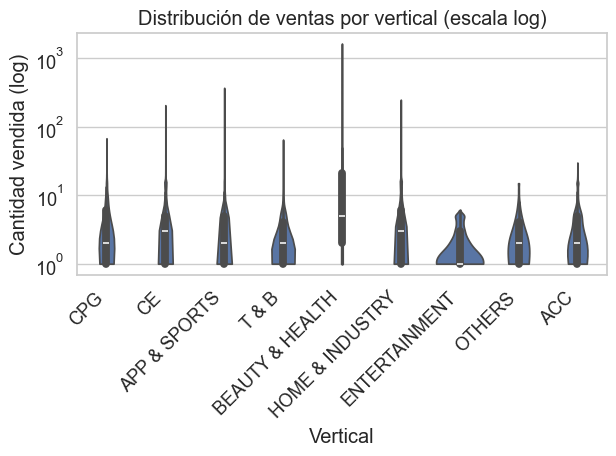

In [10]:
# Visual: violines en log (mejor legibilidad con sesgo y outliers)
ax = sns.violinplot(
    data=df_offer, x="VERTICAL", y="SOLD_QUANTITY",
    inner="box", cut=0
)

ax.set_yscale("log")
ax.set_title("Distribución de ventas por vertical (escala log)")
ax.set_xlabel("Vertical")
ax.set_ylabel("Cantidad vendida (log)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout(); plt.show()

<b> BEAUTY & HEALTH es claramente la vertical más efectiva en ventas absolutas, con diferencias estadísticamente y prácticamente significativas sobre la mayoría de las demás. </b>
- El resto de verticales muestran desempeños más parecidos entre sí, con algunas diferencias puntuales pero de menor magnitud.
- La alta dispersión sugiere que, incluso en verticales “débiles”, existen oportunidades aisladas con ventas muy altas (productos nicho de gran éxito).